# Proyek Analisis Sentimen
- **Nama : Rizky Maulana Saputra**

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import nltk
import csv
import requests
from io import  StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
pd.options.mode.chained_assignment = None
seed=0
np.random.seed(seed)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data preprocessing

In [3]:
df = pd.read_csv('ulasan_mytelkomsel.csv')

In [4]:
df = df.drop(columns=['replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion', 'userImage'])

In [5]:
df.isna().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
dtype: int64

In [6]:
df.duplicated().sum()

0

# Preprocessing Text

In [7]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text
def casefoldingText(text): 
    text = text.lower()
    return text
def tokenizingText(text): 
    text = word_tokenize(text)
    return text
def filteringText(text): 
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','gue','lu','loe','lo','kok','lah',
    'nih','tuh','dong','aja','deh','kan','lah','lahh','lho','loh','yee','ya',
    'ga','gaa','gitu','gini','wkwk','wkwkwk','haha','hehe','anjay','anjir','woi','woii','woy',
    'btw','banget','bang','min','admin','mantul','top','sip','oke','ok','kak',
    'bro','sis','cuy','gan','om','bos','bosque','ciyus','serius','wow','mantap',
    'terbaik','bagus','jelek','parah','ampas','fix','the','best','lol','lmao'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): 
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [8]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual",
    "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "dr": "dari", "yg": "yang",
    "tdk": "tidak", "udh": "sudah", "blm": "belum", "dgn": "dengan",
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
df['text_clean'] = df['content'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_akhir'] = df['text_stopword'].apply(toSentence)

# Pelabelan

In [10]:
lexicon_positive = dict()

response_positive = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response_positive.status_code == 200:
    reader = csv.reader(StringIO(response_positive.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print('Failed to fetch positive lexicon data')

lexicon_negative = dict()

response_negative = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response_negative.status_code == 200:
    reader = csv.reader(StringIO(response_negative.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print('Failed to fetch negative lexicon data')


In [11]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity = ''
    if (score>0):
        polarity = 'positive'
    elif(score<0):
        polarity = 'negative'
    else:
        polarity = 'netral'
    return score, polarity

In [12]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
negative    7174
positive    2407
netral       419
Name: count, dtype: int64


# Eksplorasi Label

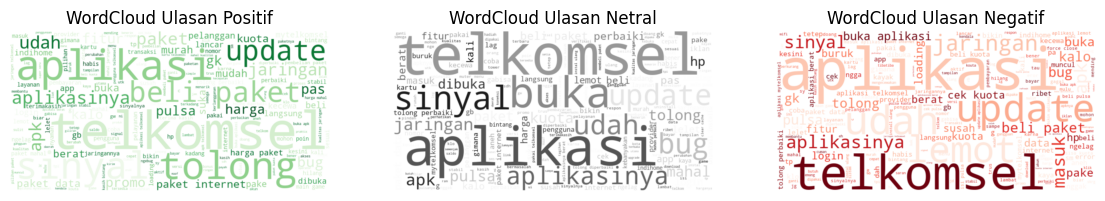

In [13]:
positive_words = ' '.join(df[df['polarity'] == 'positive']['text_akhir'].astype(str))
negative_words = ' '.join(df[df['polarity'] == 'negative']['text_akhir'].astype(str))
netral_words = ' '.join(df[df['polarity'] == 'netral']['text_akhir'].astype(str))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

wordcloud_netral = WordCloud(width=800, height=400, background_color='white', colormap='Greys').generate(netral_words)

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Positif')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Negatif')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Netral')

plt.show()

# Data Splitting dan Ekstraksi Fitur

- Feature Extraction with Tfidf and Bag of Words (CountVectorizer)
- Use Logistic Regression and SVM algorithm
- Data splitting with test size 20% and train size 80%

In [14]:
X = df['text_akhir']
y = df['polarity']
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)
bow = CountVectorizer()
X_bow = bow.fit_transform(X)
X_trainT, X_testT, y_trainT, y_testT = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_bow, y, test_size=0.2, random_state=42)
logistic = LogisticRegression()
svm = SVC()

- Logistic Regression use tfidf feature extraction

In [15]:

logistic.fit(X_trainT.toarray(),y_trainT)

y_pred_train_lr = logistic.predict(X_trainT.toarray())
y_pred_test_lr = logistic.predict(X_testT.toarray())

acc_train_lr = accuracy_score(y_pred_train_lr, y_trainT)
acc_test_lr = accuracy_score(y_pred_test_lr, y_testT)

print('Logistic Regression with Tfidf - Accuracy_train :', acc_train_lr)
print('Logistic Regression with Tfidf - Accuracy_test :', acc_test_lr)


Logistic Regression with Tfidf - Accuracy_train : 0.857125
Logistic Regression with Tfidf - Accuracy_test : 0.8565


- Logistic Regression use BoW feature extraction

In [16]:
logistic.fit(X_trainB.toarray(),y_trainB)

y_pred_train_lr = logistic.predict(X_trainB.toarray())
y_pred_test_lr = logistic.predict(X_testB.toarray())

acc_train_lr = accuracy_score(y_pred_train_lr, y_trainB)
acc_test_lr = accuracy_score(y_pred_test_lr, y_testB)

print('Logistic Regression with BoW - Accuracy_train :', acc_train_lr)
print('Logistic Regression with BoW - Accuracy_test :', acc_test_lr)


Logistic Regression with BoW - Accuracy_train : 0.992375
Logistic Regression with BoW - Accuracy_test : 0.8935


- SVM use tfidf feature extraction

In [17]:
svm.fit(X_trainT.toarray(),y_trainT)

y_pred_train_s = svm.predict(X_trainT.toarray())
y_pred_test_s = svm.predict(X_testT.toarray())

acc_train_s = accuracy_score(y_pred_train_s, y_trainT)
acc_test_s = accuracy_score(y_pred_test_s, y_testT)

print('SVM with Tidf - Accuracy_train :', acc_train_s)
print('SVM with Tidf - Accuracy_test :', acc_test_s)

SVM with Tidf - Accuracy_train : 0.918375
SVM with Tidf - Accuracy_test : 0.8505
